# Predikcia vsetkych parametrov pomocou jednej NN
## Normovane detached data

In [1]:
# Blok 1 - nacitanie kniznic
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from keras.utils import np_utils
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers import Input, Dense, concatenate, Activation, LSTM, Dropout, Flatten
from keras.models import Model
from keras.layers.merge import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

np.random.seed(1234)
pd.set_option('display.max_rows', None)

In [4]:
# Blok 2 - Funkcie pre generovanie sumu. Nastavenie pseudo-nahodneho generatora.
def generate_observation_sigma(space_obs_frac=0.5):
    """
    Draws a standard deviation of noise in light curve points from a "true" value provided in synthetic light curve.
    Noise sigma is drawn from bimodal distribution taking into account contributions from space based and earth based
    observations which have different levels of stochastic noise.

    :param space_obs_frac: ratio between earth based and space based observations
    :return: float; standard deviation of the light curve noise
    """
    earth_based_sigma = 4e-3
    space_based_sigma = 2e-4
    sigma = np.random.choice([earth_based_sigma, space_based_sigma], p=[1-space_obs_frac, space_obs_frac])
    return np.random.rayleigh(sigma)

def stochastic_noise_generator(curve):
    """
    Introduces gaussian noise into synthetic observation provided in `curve`.

    :param curve: numpy.array; normalized light curve
    :return: Tuple(numpy.array, float); normalized light curve with added noise, standard deviation of observations
    """
    sigma = generate_observation_sigma()
    return np.random.normal(curve, sigma), np.full(curve.shape, sigma)

## Data loading

In [5]:
# Blok 3 - nacitanie dat
data = pd.read_pickle("detached_all_parameters.pkl").reset_index()

In [6]:
# Blok 4 - ukazka dat
data.head()

,index,id,curve,primary__t_eff,secondary__t_eff,inclination,mass_ratio,primary__surface_potential,secondary__surface_potential,t1_t2,filter,critical_surface_potential,primary__equivalent_radius,secondary__equivalent_radius,primary__filling_factor,secondary__filling_factor
0,0,38,"[0.6055271686415179, 0.9842041250556204, 0.999...",7000,4000,1.560796,10.0,110.00005,996.5005,1.75,Bessell_U,15.09104,0.009996,0.009996,-145.333979,-1502.830354
1,1,38,"[0.608985656265516, 0.9846965713304289, 0.9998...",7000,4000,1.560796,10.0,110.00005,996.5005,1.75,Bessell_B,15.09104,0.009996,0.009996,-145.333979,-1502.830354
2,2,38,"[0.6189025614226916, 0.9837351924934223, 0.999...",7000,4000,1.560796,10.0,110.00005,996.5005,1.75,Bessell_V,15.09104,0.009996,0.009996,-145.333979,-1502.830354
3,3,38,"[0.6292771409565273, 0.9832675811171884, 0.999...",7000,4000,1.560796,10.0,110.00005,996.5005,1.75,Bessell_R,15.09104,0.009996,0.009996,-145.333979,-1502.830354
4,4,38,"[0.6543378609145588, 0.9835188424579704, 0.999...",7000,4000,1.560796,10.0,110.00005,996.5005,1.75,Bessell_I,15.09104,0.009996,0.009996,-145.333979,-1502.830354


In [7]:
# Blok 5 - vyselektovanie nahodnej vzorky dat o velkosti 100 000 zaznamov
data_sample = data.sample(n=100000)

## Train test split

In [9]:
# Blok 6 - vytvorenie pola kriviek
X = []
for row in data_sample["curve"]:
    X.append(row)
X=np.array(X)

In [10]:
# Blok 7 - vytvorenie pola features, ktore budeme predikovat
y = np.array(data_sample[[
    "primary__t_eff",
    "secondary__t_eff",
    "inclination",
    "mass_ratio",
    "primary__surface_potential",
    "secondary__surface_potential",
    "t1_t2",
    "critical_surface_potential",
    "primary__equivalent_radius",
    "secondary__equivalent_radius",
    "primary__filling_factor",
    "secondary__filling_factor"]])

In [12]:
# Blok 8 - zadefinovanie minmax scalera, normalizacia dat
scaler = MinMaxScaler()
y_minmax_scaled = scaler.fit_transform(y)
y_minmax_scaled[0]

array([1.        , 0.02439024, 0.71584635, 0.05050505, 0.17208073,
       0.0020424 , 0.7804878 , 0.08409557, 0.07311887, 0.36706089,
       0.96675942, 0.99809033])

In [13]:
# Blok 9 - rozdelenie dat na trenovaciu a testovaciu mnozinu v pomere 80/20
X_train1, X_test, y_train1, y_test = train_test_split(X, y_minmax_scaled, test_size=0.2)

In [14]:
# Blok 10 - pridanie sumu do trenovacich dat
X_train_n = []
y_train_n = []
for i in range(len(X_train1)):
    for j in range(3):
        curve = stochastic_noise_generator(X_train1[i])
        X_train_n.append(curve[0])
        y_train_n.append(y_train1[i])
X_train_n = np.array(X_train_n)
y_train_n=np.array(y_train_n)

In [15]:
# Blok 11 - vypis poctu dat v jednotlivych datovych mnozinach
print("Number of records in dataset: ", len(data),
    "\nNumber of records in sample: ", len(X),
    "\nNumber of train data without noise: ", len(X_train1),
    "\nNumber of train data with noise: ", len(X_train_n),
    "\nNumber of test data without noise: ", len(X_test))

Number of records in dataset:  1300000 
Number of records in sample:  100000 
Number of train data without noise:  80000 
Number of train data with noise:  240000 
Number of test data without noise:  20000


## Model

In [20]:
# Blok 12 - zadefinovanie architektury modelu NN
inputs = Input(shape=(400, 1))
b = Conv1D(64, kernel_size = 3, padding = "valid")(inputs)
b = MaxPooling1D(2)(b)
b = Dropout(0.2)(b)
b = LSTM(64, return_sequences=True)(b)
b = Flatten()(b)
b = Dense(64, activation='relu')(b)
x = Dense(32, activation='relu')(b)
output = Dense(12, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])

saved_model = "models/norm_detached_all_params.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor = 'val_mae', verbose = 1, save_best_only = True, mode = 'min')
early = EarlyStopping(monitor = "val_mae", mode = "min", patience = 25)
callbacks_list = [checkpoint, early]

print(model.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400, 1)]          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 64)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 64)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 199, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 199, 64)           33024     
_________________________________________________________________
flatten_1 (Flatten)          (None, 12736)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

In [22]:
# Blok 13 - trenovanie modelu
history = model.fit(X_train_n, y_train_n, validation_split = 0.1, epochs = 10, verbose = 1, callbacks = callbacks_list, batch_size = 64)

Epoch 1/10
3375/3375 [==============================] - ETA: 0s - loss: 0.0274 - mae: 0.1068 - mape: 5080980.5000
Epoch 00001: val_mae improved from inf to 0.09556, saving model to models\norm_detached_all_params.hdf5
3375/3375 [==============================] - 425s 126ms/step - loss: 0.0274 - mae: 0.1068 - mape: 5080980.5000 - val_loss: 0.0222 - val_mae: 0.0956 - val_mape: 4508048.0000
Epoch 2/10
3375/3375 [==============================] - ETA: 0s - loss: 0.0215 - mae: 0.0917 - mape: 4007379.0000
Epoch 00002: val_mae improved from 0.09556 to 0.08633, saving model to models\norm_detached_all_params.hdf5
3375/3375 [==============================] - 408s 121ms/step - loss: 0.0215 - mae: 0.0917 - mape: 4007379.0000 - val_loss: 0.0196 - val_mae: 0.0863 - val_mape: 4008381.7500
Epoch 3/10
3375/3375 [==============================] - ETA: 0s - loss: 0.0199 - mae: 0.0868 - mape: 3680181.7500
Epoch 00003: val_mae improved from 0.08633 to 0.08368, saving model to models\norm_detached_all_para

In [15]:
# Blok 14 - nacitanie modelu
model = load_model("models/norm_detached_all_params.hdf5")

### Evaluacia modelu na normovanych testovacich datach

In [17]:
# Blok 15 - evaluacia modelu na testovacich normovanych datach bez sumu
model.evaluate(X_test, y_test)

625/625 [==============================] - 27s 43ms/step - loss: 0.0143 - mean_absolute_error: 0.0676 - mean_absolute_percentage_error: 2822210.2500


[0.01428240817040205, 0.06755051761865616, 2822210.25]

In [16]:
# Blok 16 - pridanie sumu do normovanych testovacich dat
X_test_n = []
y_test_norm_n = []
for i in range(len(X_test)):
    for j in range(3):
        curve = stochastic_noise_generator(X_test[i])
        X_test_n.append(curve[0])
        y_test_norm_n.append(y_test[i])
        j += 1
X_test_n = np.array(X_test_n)
y_test_norm_n = np.array(y_test_norm_n)

In [19]:
# Blok 17 - evaluacia modelu na testovacich normovanych datach so sumom
model.evaluate(X_test_n, y_test_norm_n)

1875/1875 [==============================] - 166s 89ms/step - loss: 0.0149 - mean_absolute_error: 0.0691 - mean_absolute_percentage_error: 2925138.5000


[0.014863579533994198, 0.0691239982843399, 2925138.5]

## Prediction on normalized test data without noise

In [17]:
# Blok 18 - predikcia na testovacich datach bez sumu
y_pred_norm = model.predict(X_test)

In [19]:
# Blok 19 - uprava predikcii do podoby dataframeu
y_pred_norm_df = pd.DataFrame(y_pred_norm,
                            columns = [
                                "P_prim__t_eff",
                                "P_sec__t_eff",
                                "P_inclination",
                                "P_mass_ratio",
                                "P_prim__surface_potential",
                                "P_sec__surface_potential",
                                "P_t1_t2",
                                "P_critical_surface_potential",
                                "P_primary_equivalent_radius",
                                "P_secondary_equivalent_radius",
                                "P_primary_filling_factor",
                                "P_secondary_filling_factor"
                            ])

In [20]:
# Blok 20 - ukazka dat predikcii
y_pred_norm_df.head()

,P_prim__t_eff,P_sec__t_eff,P_inclination,P_mass_ratio,P_prim__surface_potential,P_sec__surface_potential,P_t1_t2,P_critical_surface_potential,P_primary_equivalent_radius,P_secondary_equivalent_radius,P_primary_filling_factor,P_secondary_filling_factor
0,0.432034,0.317771,0.789365,0.155243,0.061853,0.010167,0.016339,0.197784,0.283525,0.298253,0.985769,0.993489
1,0.399274,0.128573,0.833720,0.110378,0.170247,0.029986,0.128528,0.146085,0.180438,0.103930,0.961434,0.955513
2,0.402054,0.235156,0.816422,0.115417,0.006212,0.006861,0.040279,0.165227,0.502357,0.478720,1.001942,1.003117
3,0.548347,0.167892,0.755336,0.100774,0.009913,0.001751,0.172083,0.147576,0.568664,0.575040,1.005887,1.006364
4,0.594296,0.092508,0.755910,0.108059,0.089732,0.013867,0.260034,0.147744,0.156515,0.244338,0.982014,0.988140


In [21]:
# Blok 21 - vypocet priemernych hodnot predikcii
pred_mean = y_pred_norm_df.mean(axis=0)
pred_mean

P_prim__t_eff                    0.438148
P_sec__t_eff                     0.142874
P_inclination                    0.758124
P_mass_ratio                     0.153363
P_prim__surface_potential        0.138890
P_sec__surface_potential         0.015781
P_t1_t2                          0.157092
P_critical_surface_potential     0.195410
P_primary_equivalent_radius      0.299770
P_secondary_equivalent_radius    0.363952
P_primary_filling_factor         0.981066
P_secondary_filling_factor       0.986124
dtype: float32

In [22]:
# Blok 22 - vytvorenie df z testovacich normovanych dat
y_test_norm_df = pd.DataFrame(y_test,
                            columns = [
                                "P_prim__t_eff",
                                "P_sec__t_eff",
                                "P_inclination",
                                "P_mass_ratio",
                                "P_prim__surface_potential",
                                "P_sec__surface_potential",
                                "P_t1_t2",
                                "P_critical_surface_potential",
                                "P_primary_equivalent_radius",
                                "P_secondary_equivalent_radius",
                                "P_primary_filling_factor",
                                "P_secondary_filling_factor"
                            ])

In [23]:
# Blok 23 - vypocet priemernych hodnot
true_mean = y_test_norm_df.mean(axis=0)
true_mean

P_prim__t_eff                    0.452810
P_sec__t_eff                     0.149499
P_inclination                    0.766063
P_mass_ratio                     0.166421
P_prim__surface_potential        0.149158
P_sec__surface_potential         0.014329
P_t1_t2                          0.163430
P_critical_surface_potential     0.206154
P_primary_equivalent_radius      0.304588
P_secondary_equivalent_radius    0.347765
P_primary_filling_factor         0.977110
P_secondary_filling_factor       0.984284
dtype: float64

In [24]:
# Blok 24 - porovnanie skutocnych a predikovanych normovanych hodnot
eval_pred = pd.DataFrame({'attribute': true_mean.index,
            'avg_true': true_mean.values,
            'avg_pred': pred_mean.values,
            'abs_error_%': 100*(abs(true_mean.values - pred_mean.values))})

In [25]:
# Blok 25 - ukazka dat porovnania
eval_pred

,attribute,avg_true,avg_pred,abs_error_%
0,P_prim__t_eff,0.452810,0.438148,1.466153
1,P_sec__t_eff,0.149499,0.142874,0.662518
2,P_inclination,0.766063,0.758124,0.793842
3,P_mass_ratio,0.166421,0.153363,1.305759
4,P_prim__surface_potential,0.149158,0.138890,1.026814
5,P_sec__surface_potential,0.014329,0.015781,0.145175
6,P_t1_t2,0.163430,0.157092,0.633843
7,P_critical_surface_potential,0.206154,0.195410,1.074394
8,P_primary_equivalent_radius,0.304588,0.299770,0.481825
9,P_secondary_equivalent_radius,0.347765,0.363952,1.618761


Text(0, 0.5, 'Avg')

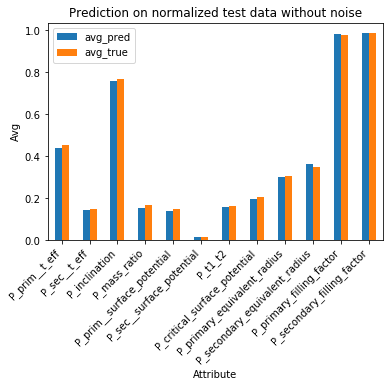

In [26]:
# Blok 26 - grafova podoba porovnania
x = np.arange(len(eval_pred))
eval_pred[["avg_pred", "avg_true"]].plot(kind="bar")
plt.title("Prediction on normalized test data without noise")
plt.xlabel("Attribute")
plt.xticks(x, eval_pred.attribute, rotation=45, ha='right')
plt.ylabel("Avg")

### Denormalization

In [27]:
# Blok 27 - spatna normalizacia predikcii
denormalized = scaler.inverse_transform(y_pred_norm)

In [29]:
# Blok 28 - vytvorenie dataframeu z denormlaizovanych predikcii
denorm_pred = pd.DataFrame(denormalized,
                            columns = [
                                "P_prim__t_eff",
                                "P_sec__t_eff",
                                "P_inclination",
                                "P_mass_ratio",
                                "P_prim__surface_potential",
                                "P_sec__surface_potential",
                                "P_t1_t2",
                                "P_critical_surface_potential",
                                "P_primary_equivalent_radius",
                                "P_secondary_equivalent_radius",
                                "P_primary_filling_factor",
                                "P_secondary_filling_factor"
                            ])

In [30]:
# Blok 29 - ukazka dat denormalizovanych predikcii
denorm_pred.head()

,P_prim__t_eff,P_sec__t_eff,P_inclination,P_mass_ratio,P_prim__surface_potential,P_sec__surface_potential,P_t1_t2,P_critical_surface_potential,P_primary_equivalent_radius,P_secondary_equivalent_radius,P_primary_filling_factor,P_secondary_filling_factor
0,21713.390625,17028.617188,1.395322,1.636901,8.698860,12.150850,1.167473,4.556396,0.165042,0.173096,-21.386898,-9.784791
1,20370.228516,9271.480469,1.432273,1.192739,20.403212,31.860313,2.317413,3.877478,0.108669,0.066830,-57.957951,-66.856216
2,20484.207031,13641.383789,1.417863,1.242624,2.690766,8.863263,1.412860,4.128850,0.284711,0.271785,2.918470,4.684364
3,26482.248047,10883.576172,1.366974,1.097659,3.090334,3.780988,2.763849,3.897063,0.320970,0.324458,8.847303,9.564446
4,28366.121094,7792.821777,1.367452,1.169786,11.709270,15.829687,3.665346,3.899266,0.095586,0.143613,-27.030075,-17.823490


In [33]:
# Blok 30 - vypocet priemernych hodnot predikcii pre jednotlive parametre
pred_mean = denorm_pred.mean(axis=0)
pred_mean

P_prim__t_eff                    21964.074219
P_sec__t_eff                      9857.833984
P_inclination                        1.369297
P_mass_ratio                         1.618292
P_prim__surface_potential           17.017254
P_sec__surface_potential            17.733107
P_t1_t2                              2.610183
P_critical_surface_potential         4.525213
P_primary_equivalent_radius          0.173925
P_secondary_equivalent_radius        0.209024
P_primary_filling_factor           -28.454815
P_secondary_filling_factor         -20.850000
dtype: float32

In [32]:
# Blok 31 - vytvorenie df testovacich hodnot a vypocet priemeru pre jednotlive parametre
y_test_df = pd.DataFrame(y,
                            columns = [
                                "P_prim__t_eff",
                                "P_sec__t_eff",
                                "P_inclination",
                                "P_mass_ratio",
                                "P_prim__surface_potential",
                                "P_sec__surface_potential",
                                "P_t1_t2",
                                "P_critical_surface_potential",
                                "P_primary_equivalent_radius",
                                "P_secondary_equivalent_radius",
                                "P_primary_filling_factor",
                                "P_secondary_filling_factor"
                            ])
test_mean = y_test_df.mean(axis=0)
test_mean

P_prim__t_eff                    22519.450000
P_sec__t_eff                     10157.140000
P_inclination                        1.375792
P_mass_ratio                         1.749395
P_prim__surface_potential           18.224785
P_sec__surface_potential            16.789932
P_t1_t2                              2.660959
P_critical_surface_potential         4.672578
P_primary_equivalent_radius          0.176043
P_secondary_equivalent_radius        0.199422
P_primary_filling_factor           -33.829752
P_secondary_filling_factor         -24.457384
dtype: float64

In [38]:
# Blok 32 - vytvorenie df na porovnanie avg hodnot skutocnych a predikovanych
eval_pred = pd.DataFrame({'attribute': test_mean.index,
            'avg_true': test_mean.values,
            'avg_pred': pred_mean.values,
            'MAE': abs(test_mean.values - pred_mean.values)})
eval_pred

,attribute,avg_true,avg_pred,MAE
0,P_prim__t_eff,22519.450000,21964.074219,555.375781
1,P_sec__t_eff,10157.140000,9857.833984,299.306016
2,P_inclination,1.375792,1.369297,0.006494
3,P_mass_ratio,1.749395,1.618292,0.131103
4,P_prim__surface_potential,18.224785,17.017254,1.207532
5,P_sec__surface_potential,16.789932,17.733107,0.943175
6,P_t1_t2,2.660959,2.610183,0.050776
7,P_critical_surface_potential,4.672578,4.525213,0.147365
8,P_primary_equivalent_radius,0.176043,0.173925,0.002117
9,P_secondary_equivalent_radius,0.199422,0.209024,0.009602


### Predikcia na normalizovanych datach so sumom

In [40]:
# Blok 33 - predikcia na normovanych datach so sumom
y_pred_norm_n = model.predict(X_test_n)

In [41]:
# Blok 34 - uprava predikcii do podoby dataframeu
y_pred_norm_n_df = pd.DataFrame(y_pred_norm_n,
                            columns = [
                                "P_prim__t_eff",
                                "P_sec__t_eff",
                                "P_inclination",
                                "P_mass_ratio",
                                "P_prim__surface_potential",
                                "P_sec__surface_potential",
                                "P_t1_t2",
                                "P_critical_surface_potential",
                                "P_primary_equivalent_radius",
                                "P_secondary_equivalent_radius",
                                "P_primary_filling_factor",
                                "P_secondary_filling_factor"
                            ])

In [42]:
# Blok 35 - ukazka dat predikcii
y_pred_norm_n_df.head()

,P_prim__t_eff,P_sec__t_eff,P_inclination,P_mass_ratio,P_prim__surface_potential,P_sec__surface_potential,P_t1_t2,P_critical_surface_potential,P_primary_equivalent_radius,P_secondary_equivalent_radius,P_primary_filling_factor,P_secondary_filling_factor
0,0.465119,0.341118,0.788943,0.168161,0.065707,0.010350,0.011449,0.213275,0.264163,0.310487,0.985980,0.994554
1,0.432457,0.318370,0.788877,0.155687,0.061972,0.010154,0.016361,0.198199,0.283024,0.299281,0.985790,0.993509
2,0.449705,0.326637,0.802305,0.160642,0.066520,0.012944,0.015032,0.205083,0.270194,0.294737,0.985510,0.991389
3,0.345672,0.141229,0.804684,0.132810,0.096499,0.029053,0.097830,0.173284,0.201695,0.123133,0.973148,0.957855
4,0.392422,0.168281,0.738257,0.112729,0.111923,0.025177,0.081593,0.156238,0.192680,0.175832,0.968381,0.962399


In [43]:
# Blok 36 - vypocet priemernych hodnot predikcii
n_pred_mean = y_pred_norm_n_df.mean(axis=0)
n_pred_mean

P_prim__t_eff                    0.439557
P_sec__t_eff                     0.143509
P_inclination                    0.758005
P_mass_ratio                     0.152982
P_prim__surface_potential        0.139204
P_sec__surface_potential         0.015855
P_t1_t2                          0.156877
P_critical_surface_potential     0.195015
P_primary_equivalent_radius      0.298788
P_secondary_equivalent_radius    0.365059
P_primary_filling_factor         0.980982
P_secondary_filling_factor       0.986136
dtype: float32

In [44]:
# Blok 37 - vytvorenie df z testovacich dat so sumom
y_test_norm_n_df = pd.DataFrame(y_test_norm_n,
                            columns = [
                                "P_prim__t_eff",
                                "P_sec__t_eff",
                                "P_inclination",
                                "P_mass_ratio",
                                "P_prim__surface_potential",
                                "P_sec__surface_potential",
                                "P_t1_t2",
                                "P_critical_surface_potential",
                                "P_primary_equivalent_radius",
                                "P_secondary_equivalent_radius",
                                "P_primary_filling_factor",
                                "P_secondary_filling_factor"
                            ])

In [45]:
# Blok 38 - vypocet priemernych hodnot
n_true_mean = y_test_norm_n_df.mean(axis=0)
n_true_mean

P_prim__t_eff                    0.452810
P_sec__t_eff                     0.149499
P_inclination                    0.766063
P_mass_ratio                     0.166421
P_prim__surface_potential        0.149158
P_sec__surface_potential         0.014329
P_t1_t2                          0.163430
P_critical_surface_potential     0.206154
P_primary_equivalent_radius      0.304588
P_secondary_equivalent_radius    0.347765
P_primary_filling_factor         0.977110
P_secondary_filling_factor       0.984284
dtype: float64

In [46]:
# Blok 39 - vyvorenie df na porovnanie priemernych testovacich a predikovanych hodnot, normovane data
n_eval_pred = pd.DataFrame({'attribute': n_true_mean.index,
            'avg_true': n_true_mean.values,
            'avg_pred': n_pred_mean.values,
            'MAE': abs(n_true_mean.values - n_pred_mean.values)})
n_eval_pred

,attribute,avg_true,avg_pred,MAE
0,P_prim__t_eff,0.452810,0.439557,0.013253
1,P_sec__t_eff,0.149499,0.143509,0.005989
2,P_inclination,0.766063,0.758005,0.008057
3,P_mass_ratio,0.166421,0.152982,0.013439
4,P_prim__surface_potential,0.149158,0.139204,0.009954
5,P_sec__surface_potential,0.014329,0.015855,0.001527
6,P_t1_t2,0.163430,0.156877,0.006553
7,P_critical_surface_potential,0.206154,0.195015,0.011138
8,P_primary_equivalent_radius,0.304588,0.298788,0.005800
9,P_secondary_equivalent_radius,0.347765,0.365059,0.017294


Text(0, 0.5, 'Avg')

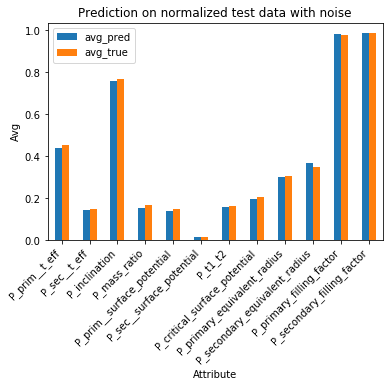

In [27]:
# Blok 40 - grafova podoba porovnania
x = np.arange(len(n_eval_pred))
n_eval_pred[["avg_pred", "avg_true"]].plot(kind="bar")
plt.title("Prediction on normalized test data with noise")
plt.xlabel("Attribute")
plt.xticks(x, n_eval_pred.attribute, rotation=45, ha='right')
plt.ylabel("Avg")

### Denormalization

In [47]:
# Blok 41 - spatna denormalizacia predikcii, vytvorenie dataframeu
denormalized_n = scaler.inverse_transform(y_pred_norm_n)
denorm_n_pred = pd.DataFrame(denormalized_n,
                            columns = [
                                "P_prim__t_eff",
                                "P_sec__t_eff",
                                "P_inclination",
                                "P_mass_ratio",
                                "P_prim__surface_potential",
                                "P_sec__surface_potential",
                                "P_t1_t2",
                                "P_critical_surface_potential",
                                "P_primary_equivalent_radius",
                                "P_secondary_equivalent_radius",
                                "P_primary_filling_factor",
                                "P_secondary_filling_factor"
                            ])

In [50]:
# Blok 42 - ukazka dat
denorm_n_pred.head()

,P_prim__t_eff,P_sec__t_eff,P_inclination,P_mass_ratio,P_prim__surface_potential,P_sec__surface_potential,P_t1_t2,P_critical_surface_potential,P_primary_equivalent_radius,P_secondary_equivalent_radius,P_primary_filling_factor,P_secondary_filling_factor
0,23069.884766,17985.830078,1.394971,1.764798,9.115028,12.332879,1.117355,4.759816,0.154454,0.179787,-21.069891,-8.184701
1,21730.755859,17053.150391,1.394916,1.641296,8.711674,12.138206,1.167700,4.561847,0.164768,0.173658,-21.355547,-9.754962
2,22437.886719,17392.103516,1.406102,1.690352,9.202767,14.912174,1.154073,4.652238,0.157752,0.171174,-21.776283,-12.940541
3,18172.566406,9790.380859,1.408084,1.414821,12.439978,30.931646,2.002754,4.234660,0.120293,0.077331,-40.354721,-63.336521
4,20089.316406,10899.501953,1.352746,1.216016,14.105429,27.077154,1.836332,4.010816,0.115363,0.106150,-47.517998,-56.508617


In [51]:
# Blok 43 - vypocet priemernych hodnot
n_pred_mean = denorm_n_pred.mean(axis=0)
n_pred_mean

P_prim__t_eff                    22021.871094
P_sec__t_eff                      9883.876953
P_inclination                        1.369198
P_mass_ratio                         1.614515
P_prim__surface_potential           17.051184
P_sec__surface_potential            17.807707
P_t1_t2                              2.608001
P_critical_surface_potential         4.520045
P_primary_equivalent_radius          0.173390
P_secondary_equivalent_radius        0.209630
P_primary_filling_factor           -28.575169
P_secondary_filling_factor         -20.845806
dtype: float32

In [55]:
# Blok 44 - spatna denormalizacia testovacich dat, vytvorenie dataframeu
y_test_n_denorm = scaler.inverse_transform(y_test_norm_n)
y_test_df = pd.DataFrame(y_test_n_denorm,
                            columns = [
                                "P_prim__t_eff",
                                "P_sec__t_eff",
                                "P_inclination",
                                "P_mass_ratio",
                                "P_prim__surface_potential",
                                "P_sec__surface_potential",
                                "P_t1_t2",
                                "P_critical_surface_potential",
                                "P_primary_equivalent_radius",
                                "P_secondary_equivalent_radius",
                                "P_primary_filling_factor",
                                "P_secondary_filling_factor"
                            ])
y_test_df.head()

,P_prim__t_eff,P_sec__t_eff,P_inclination,P_mass_ratio,P_prim__surface_potential,P_sec__surface_potential,P_t1_t2,P_critical_surface_potential,P_primary_equivalent_radius,P_secondary_equivalent_radius,P_primary_filling_factor,P_secondary_filling_factor
0,35000.0,30000.0,1.397338,2.5,13.615222,10.329518,1.166667,5.94524,0.090010,0.24977,-12.574528,-7.187790
1,35000.0,30000.0,1.397338,2.5,13.615222,10.329518,1.166667,5.94524,0.090010,0.24977,-12.574528,-7.187790
2,35000.0,30000.0,1.397338,2.5,13.615222,10.329518,1.166667,5.94524,0.090010,0.24977,-12.574528,-7.187790
3,6000.0,5000.0,1.334076,10.0,30.001273,44.340251,1.200000,15.09104,0.050001,0.20966,-22.832011,-44.789259
4,6000.0,5000.0,1.334076,10.0,30.001273,44.340251,1.200000,15.09104,0.050001,0.20966,-22.832011,-44.789259


In [56]:
# Blok 45 - vypocet priemernych hodnot
true_n_mean = y_test_df.mean(axis=0)
true_n_mean

P_prim__t_eff                    22565.200000
P_sec__t_eff                     10129.450000
P_inclination                        1.375910
P_mass_ratio                         1.747564
P_prim__surface_potential           18.126015
P_sec__surface_potential            16.289401
P_t1_t2                              2.675162
P_critical_surface_potential         4.666303
P_primary_equivalent_radius          0.176560
P_secondary_equivalent_radius        0.200172
P_primary_filling_factor           -34.399594
P_secondary_filling_factor         -23.618069
dtype: float64

In [58]:
# Blok 46 - vytvorenie df na porovnanie priemernych testovacich a priemernych hodnot pre jednotlive atributy
eval_pred = pd.DataFrame({'attribute': true_n_mean.index,
            'avg_true': true_n_mean.values,
            'avg_pred': n_pred_mean.values,
            'MAE': abs(true_n_mean.values - n_pred_mean.values)})
eval_pred

,attribute,avg_true,avg_pred,MAE
0,P_prim__t_eff,22565.200000,22021.871094,543.328906
1,P_sec__t_eff,10129.450000,9883.876953,245.573047
2,P_inclination,1.375910,1.369198,0.006712
3,P_mass_ratio,1.747564,1.614515,0.133050
4,P_prim__surface_potential,18.126015,17.051184,1.074831
5,P_sec__surface_potential,16.289401,17.807707,1.518306
6,P_t1_t2,2.675162,2.608001,0.067161
7,P_critical_surface_potential,4.666303,4.520045,0.146258
8,P_primary_equivalent_radius,0.176560,0.173390,0.003171
9,P_secondary_equivalent_radius,0.200172,0.209630,0.009458
